In [2]:
import time
import os
import numpy as np

import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim 

torch.manual_seed(1) # set the random seed

#Load Data

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Define pathes
daniel_dir = '/content/drive/MyDrive/APS360/Project_dataset/'
charlie_dir = '/content/drive/MyDrive/ECE/2022Winter/APS360/Dataset/'
jeff_dir = '/content/drive/MyDrive/APS360-Project/Dataset/'
# Choose path
data_dir = charlie_dir

# define training and test data directories
train_dir = os.path.join(data_dir, 'train/')
val_dir = os.path.join(data_dir, 'validation/')
test_dir = os.path.join(data_dir, 'test/')

In [7]:
# load and transform data using ImageFolder
data_transform = transforms.Compose([transforms.Resize(224), transforms.ToTensor()])

train_data = datasets.ImageFolder(train_dir, transform=data_transform)
val_data = datasets.ImageFolder(val_dir, transform=data_transform)
test_data = datasets.ImageFolder(test_dir, transform=data_transform)

# print out some data stats
print('Num training images: ', len(train_data))
print('Num validation images: ', len(val_data))
print('Num test images: ', len(test_data))

Num training images:  18000
Num validation images:  3862
Num test images:  3860


#Training Functions

In [15]:
def train(model, train_data, val_data, batch_size=64, learning_rate=0.01, num_epochs=1):
  torch.manual_seed(1000) # set the random seed

  train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)

  iters, train_acc, val_acc, train_f1, val_f1 = np.zeros(num_epochs), np.zeros(num_epochs), np.zeros(num_epochs), np.zeros(num_epochs), np.zeros(num_epochs)

  # training
  n = 0 # the number of iterations
  start_time=time.time()
  for epoch in range(num_epochs):
    for imgs, labels in iter(train_loader):
    
      #############################################
      #To Enable GPU Usage
      if use_cuda and torch.cuda.is_available():
        imgs = imgs.cuda()
        labels = labels.cuda()
      #############################################
    
      out = model(imgs)             # forward pass
      loss = criterion(out, labels) # compute the total loss
      loss.backward()               # backward pass (compute parameter updates)
      optimizer.step()              # make the updates for each parameter
      optimizer.zero_grad()         # a clean up step for PyTorch

    # save the current training statistics
    iters[epoch] = n

    train_acc[epoch], train_f1[epoch] = get_stastics(model, train_data, batch_size=batch_size) # compute training 
    val_acc[epoch], val_f1[epoch] = get_stastics(model, val_data, batch_size=batch_size)  # compute validation 

    n += 1

    print ("Epoch %d Finished." % epoch, "Time per Epoch: % 6.2f s. "% ((time.time()-start_time) / (epoch +1)), 
           "Validation Accuracy is", val_acc[epoch], ". Validation F1 score is", val_f1[epoch])

  # save models for later usage
  # model_path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(model.name, batch_size, learning_rate, num_epochs)
  model_path = "/content/drive/MyDrive/ECE/2022Winter/APS360/APS 360 Project/Models/GoogLeNet/model_{0}_bs{1}_lr{2}_epoch{3}".format(model.name, batch_size, learning_rate, num_epochs)
  torch.save(model.state_dict(), model_path)

  end_time= time.time()
  
  # plotting
  plt.title("F1 Score Curve")
  plt.plot(iters, train_f1, label="Training")
  plt.plot(iters, val_f1, label="Validation")
  plt.xlabel("Iterations")
  plt.ylabel("F1 Score")
  plt.legend(loc='best')
  plt.show()

  plt.title("Accuracy Curve")
  plt.plot(iters, train_acc, label="Training")
  plt.plot(iters, val_acc, label="Validation")    
  plt.xlabel("Iterations")
  plt.ylabel("Accuracy")
  plt.legend(loc='best')
  plt.show()

  print("Final Training Accuracy: {}".format(train_acc[-1]))
  print("Final Validation Accuracy: {}".format(val_acc[-1]))
  print("Final Training F1 Score: {}".format(train_f1[-1]))
  print("Final Validation F1 Score: {}".format(val_f1[-1]))

In [9]:
def get_stastics(model, data, batch_size):
  # Load data
  data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size)

  correct, total = 0, 0
  running_corrects, running_loss = 0.0, 0
  criterion = nn.CrossEntropyLoss()

  for imgs, labels in data_loader:
    #############################################
    #To Enable GPU Usage
    if use_cuda and torch.cuda.is_available():
      imgs = imgs.cuda()
      labels = labels.cuda()
    #############################################
    
    output = model(imgs)
    loss = criterion(output, labels)
    
    #select index with maximum prediction score
    preds = output.max(1, keepdim=True)[1]

    # Get Accuracy
    correct += preds.eq(labels.view_as(preds)).sum().item()
    total += imgs.shape[0]
    accuracy = correct / total

    # Get F1 score
    running_loss += loss.item() * imgs.size(0)
    running_corrects += torch.sum(preds == labels.data)

    from sklearn.metrics import f1_score

    f1_score = f1_score(labels.cpu().data, preds.cpu(), average='micro')

  return accuracy, f1_score

#Model

In [16]:
import torchvision.models
googlenet = torchvision.models.googlenet(pretrained=True)
model = googlenet
model.name = 'GoogLeNet1'
model.fc = nn.Linear(1024, 6)

In [17]:
model2 = googlenet
model2.name = 'GoogLeNet2'
model2.fc = nn.Sequential(
    nn.Linear(1024, 256),
    nn.Linear(256, 6)
)

#Testing

In [ ]:
# training
use_cuda = True

if use_cuda and torch.cuda.is_available():
  torch.cuda.empty_cache()
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train(model,train_data, val_data, 128, 1e-4, 10)

CUDA is available!  Training on GPU ...
Epoch 0 Finished. Time per Epoch:  136.27 s.  Validation Accuracy is 0.2055929570170896 . Validation F1 score is 0.22727272727272727
Epoch 1 Finished. Time per Epoch:  136.27 s.  Validation Accuracy is 0.20870015535991715 . Validation F1 score is 0.13636363636363635
Epoch 2 Finished. Time per Epoch:  136.32 s.  Validation Accuracy is 0.20326255825996892 . Validation F1 score is 0.18181818181818182
Epoch 3 Finished. Time per Epoch:  136.10 s.  Validation Accuracy is 0.20947695494562402 . Validation F1 score is 0.13636363636363635
Epoch 4 Finished. Time per Epoch:  135.89 s.  Validation Accuracy is 0.2099948213360953 . Validation F1 score is 0.13636363636363635
Epoch 5 Finished. Time per Epoch:  135.80 s.  Validation Accuracy is 0.20973588814085967 . Validation F1 score is 0.18181818181818182
Epoch 6 Finished. Time per Epoch:  135.74 s.  Validation Accuracy is 0.2102537545313309 . Validation F1 score is 0.13636363636363635


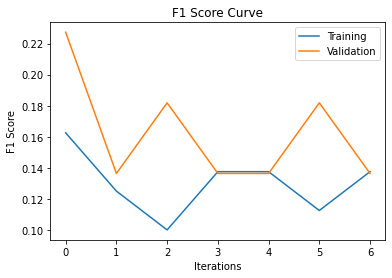

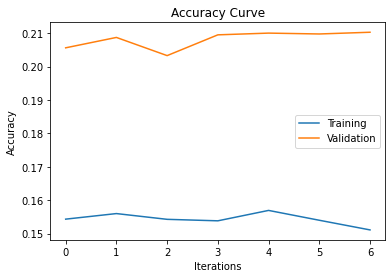

Final Training Accuracy: 0.1511111111111111
Final Validation Accuracy: 0.2102537545313309
Final Training F1 Score: 0.1375
Final Validation F1 Score: 0.13636363636363635


In [19]:
# training
use_cuda = True

if use_cuda and torch.cuda.is_available():
  torch.cuda.empty_cache()
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train(model,train_data, val_data, batch_size=128, learning_rate=5e-5, num_epochs=7)

In [20]:
# Best model
if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')

# Test Accuracy of the best Model
test_acc, test_f1_score = get_stastics(model, test_data, batch_size=32)

print("Test Accuracy:", test_acc)
print("Test F1 Score:", test_f1_score)

CUDA is available!  Training on GPU ...
Test Accuracy: 0.20829015544041452
Test F1 Score: 0.10000000000000002
